<a href="https://colab.research.google.com/github/justinkoh/AiHack20/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compressor Analytics Dataset**


---

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import urllib.request
import zipfile
import os

print("Starting download ...")
urls = [
    "https://github.com/aihack20/shell_challenge/releases/download/data/clean_dataset.zip",
    "https://github.com/aihack20/shell_challenge/releases/download/data/raw_dataset.zip",
]
os.makedirs("shell_data", exist_ok=True)
for url in urls:
    with urllib.request.urlopen(url) as src:
        with open("tmp.zip", "wb") as dest:
            dest.write(src.read())
    print("Unpacking archive ...")
    with zipfile.ZipFile("tmp.zip") as f:
        f.extractall("shell_data")
print("Done!")

Starting download ...
Unpacking archive ...
Unpacking archive ...
Done!


In [0]:
%pip install pandas matplotlib

In [0]:
import pandas as pd

In [0]:
clean_data = pd.read_csv("shell_data/clean_dataset.csv")
clean_data = clean_data.drop(columns='original_index') #drop old index
clean_data = clean_data.interpolate() #fill in missing gaps
clean_data = clean_data.apply(lambda x : x/x.max(), axis=0)


In [0]:
clean_data.describe()

,Temperature Indicating 0,Flow Rate Difference 1,Flow Rate Indicating 2,Flow Rate Indicating 3,Flow Rate Indicating 4,Flow Rate Indicating 5,Flow Rate Indicating 6,Flow Rate Indicating 7,Flow Rate Indicating 8,Flow Rate Transmitting 9,Flow Rate Transmitting 10,Flow Rate Transmitting 11,Flow Rate Transmitting 12,Flow Rate Actuating Element 13,Flow Rate Solenoid 14,Gauging Difference 15,Time Control Unknown 16,Level Indicating 17,Level Indicating 18,Pressure Controller 19,Pressure Difference 20,Pressure Difference 21,Pressure Difference 22,Pressure Difference 23,Pressure Difference 24,Pressure Difference 25,Pressure Difference 26,Pressure Difference 27,Pressure Difference 28,Pressure Difference 29,Pressure Difference 30,Pressure Difference 31,Pressure Difference 32,Pressure Indicating 33,Pressure Indicating 34,Pressure Indicating 35,Pressure Indicating 36,Pressure Indicating 37,Pressure Indicating 38,Pressure Indicating 39,...,Unknown Solenoid 322,Unknown Solenoid 323,Unknown Solenoid 324,Unknown Solenoid 325,Unknown Solenoid 326,Unknown Solenoid 327,Classified Status 328,Classified Indicating 329,Classified Indicating 330,Classified Indicating 331,Classified Indicating 332,Classified Indicating 333,Classified Indicating 334,Classified Indicating 335,Classified Indicating 336,Unknown Indicating 337,Unknown Indicating 338,Unknown Indicating 339,Unknown Indicating 340,Unknown Indicating 341,Unknown Indicating 342,Flow Rate Difference 343,Flow Rate Indicating 344,Flow Rate Actuating Element 345,Level Emergency Action 346,Pressure Difference 347,Pressure Difference 348,Pressure Difference 349,Pressure Difference 350,Pressure Indicating 351,Pressure Indicating 352,Pressure Indicating 353,Pressure Emergency Action 354,Temperature Controller 355,Temperature Indicating 356,Temperature Indicating 357,Temperature Indicating 358,Temperature Indicating 359,Temperature Indicating 360,Pressure Emergency Action 361
count,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,...,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000,106710.000000
mean,0.884439,0.703895,0.846996,0.831705,0.067578,0.054465,0.563795,0.805604,0.777668,0.361586,0.449701,0.847643,0.861174,0.096683,0.953088,0.002533,0.967429,0.437813,0.405565,0.151585,0.186437,0.041519,0.782029,0.623804,-0.018715,0.617749,0.288289,0.267228,0.600454,0.528821,0.542196,0.678177,0.000890,0.872522,0.825416,0.944553,0.825719,0.815564,0.848576,0.887598,...,0.773027,0.534476,0.497089,0.671464,0.409934,0.698922,0.013344,0.474285,0.581710,0.743124,0.728319,0.793217,0.414895,0.338739,0.012070,-0.275188,-1.067578,0.317371,0.283674,0.375486,0.065513,0.431796,0.649958,0.148146,0.438814,0.187817,0.313172,0.394019,0.086009,0.916809,0.941163,0.635380,0.635990,0.338507,0.805418,0.893693,0.590274,0.693533,0.712463,0.630963
std,0.056668,0.073350,0.058161,0.105683,0.139488,0.167893,0.031594,0.096468,0.130667,0.024249,0.029576,0.058543,0.066920,0.077251,0.052948,0.009509,0.044270,0.103544,0.115414,0.079973,0.064822,0.017963,0.07

#**Relationship Between Temperature and Pressure**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
%matplotlib inline

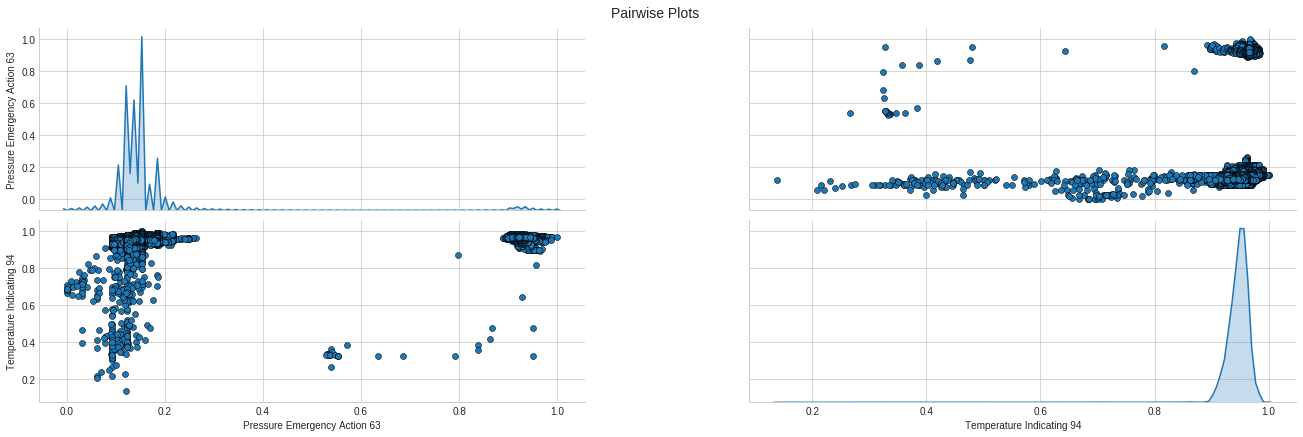

In [0]:
# Pair-wise Scatter Plots
series = clean_data.copy()
cols = ["Pressure Emergency Action 63", "Temperature Indicating 94"]
pp = sns.pairplot(series[cols], height=3, aspect=3,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots', fontsize=14)

# **K Means Clustering to Find Common Features**

In [0]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [0]:
x = clean_data.iloc[:, [1,2,3,4,5,6,7,8,9,10]].values

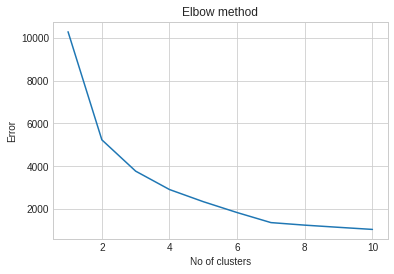

In [0]:
#get optimal clusters-elbow at 2 and 6? use 6 as least steep
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [0]:
kmeans = KMeans(n_clusters=7)
y_kmeans = kmeans.fit_predict(x)

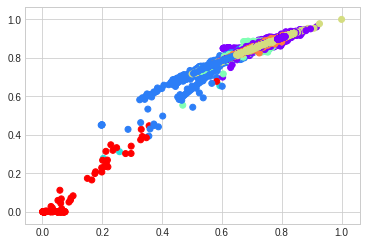

In [0]:
plt.scatter(x[:,0],x[:,1],c=y_kmeans,cmap='rainbow') #attempt at viewing data

# **Anomaly Detection of Shell Low Pressure Compressor using ADTK library**
---



In [0]:
#required libraries
#import pandas as pd
!pip3 install adtk
from adtk.data import validate_series
from adtk.data import to_events
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

MessageError: ignored

In [0]:
#from datetime import time
data = clean_data.copy()
data.index = pd.to_datetime(data.index)
validate_data = validate_series(data) #run data validation n the data
data.index= pd.RangeIndex(106710)

In [0]:
detector = OutlierDetector(LocalOutlierFactor(contamination=0.10))
anomalies = detector.fit_detect(validate_data)

In [0]:
pred_anomalies = anomalies.copy()
pred_anomalies.index = pd.RangeIndex(106710)

In [0]:
known_anomalies = pd.read_csv("known_anomalies.csv", index_col=0, header=None)
known_anomalies = known_anomalies.iloc[0:,0]
dt_known_anomalies = known_anomalies.copy()
dt_known_anomalies.index = pd.to_datetime(dt_known_anomalies.index)
dt_known_anomalies = to_events(dt_known_anomalies)

# **Data Visualisation and Feature Inference**


---


In [0]:
from adtk.visualization import plot
#using validate_data that has datetime index
def show_anomaly(feature):
  #assert(stop < 106710)
  plot(validate_data.iloc[:, feature],anomaly_pred=anomalies, anomaly_true=dt_known_anomalies, ap_marker_on_curve=True, ap_color='red', at_color='orange')


In [0]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

def show(feature, start=0, stop=106710):
  fig = plt.figure(figsize = (10,5))
  plt.title(data.columns[0], fontsize=20)
  plt.xlim = (start, stop)
  plt.ylim = (0,1)
  plt.xlabel('Time', fontsize=10)
  plt.ylabel(data.columns[feature], fontsize=10)
  p = sns.lineplot(data = data.iloc[start:stop, feature], color='b')
  plt.setp(p.lines, linewidth=3)
  plt.show()

In [0]:
anomaly_points = [i for i,t in enumerate(pred_anomalies.to_list()) if t is True]
anomaly_dict = {0:[]}
period = 0
for i in range(len(anomaly_points)):
  anomaly_dict[period].append(anomaly_points[i])
  if(i !=len(anomaly_points) -1):
    if(anomaly_points[i+1] - anomaly_points[i] > 50):
      period +=1
      anomaly_dict[period] = []

anomaly_periods = [v for k,v in anomaly_dict.items() if len(v) > 75]

def show_anomaly_periods(feature):
  for i in anomaly_periods:
    show(feature, i[0], i[-1])

def feature_analysis(feature):
  show_anomaly(feature)
  show_anomaly_periods(feature)


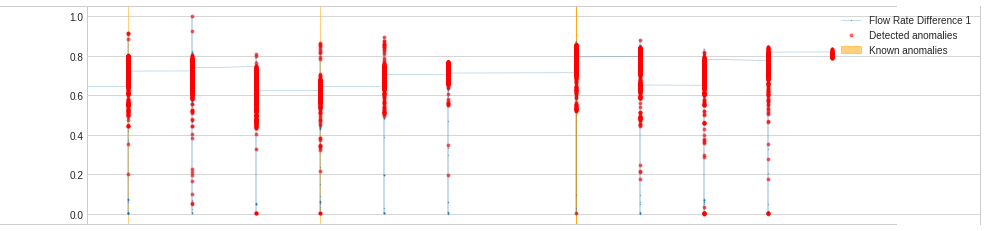

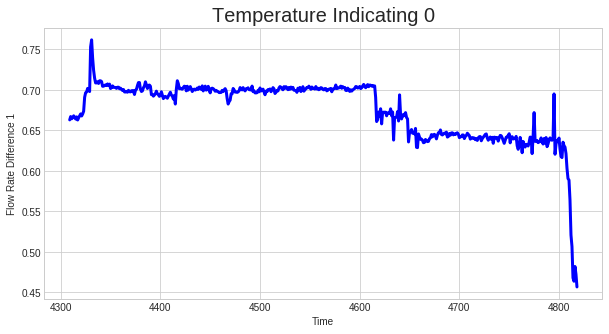

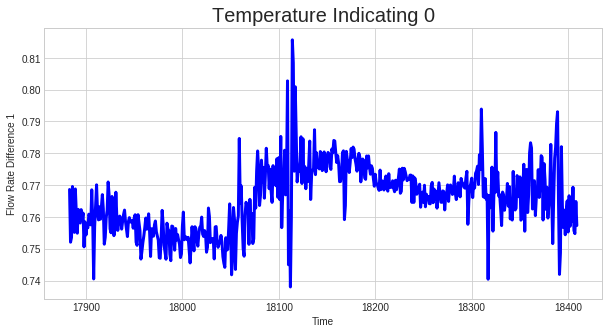

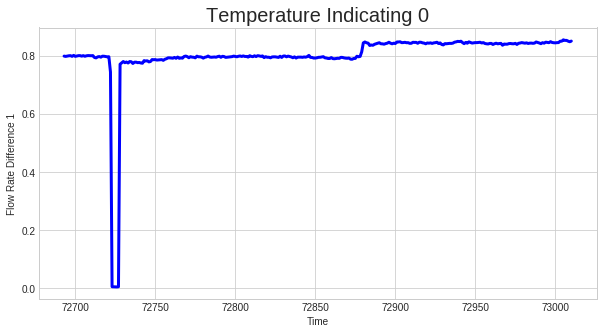

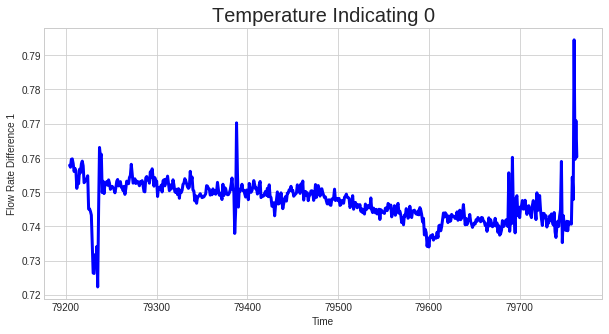

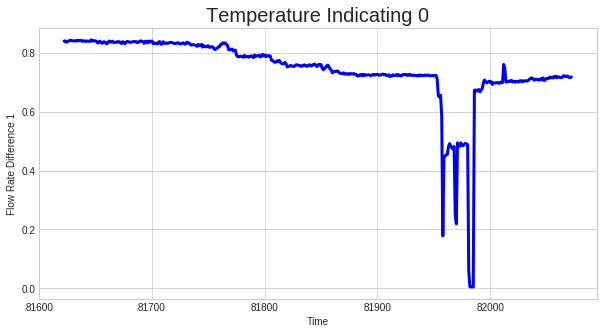

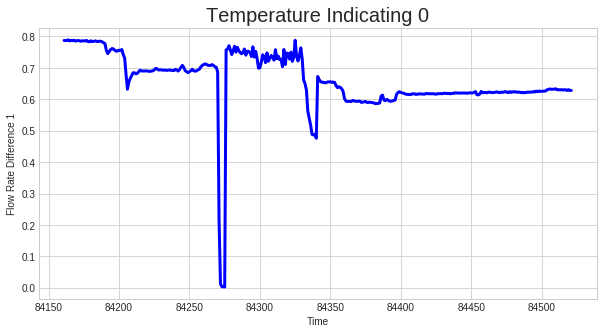

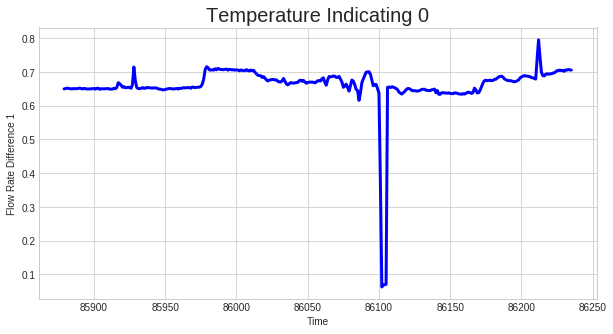

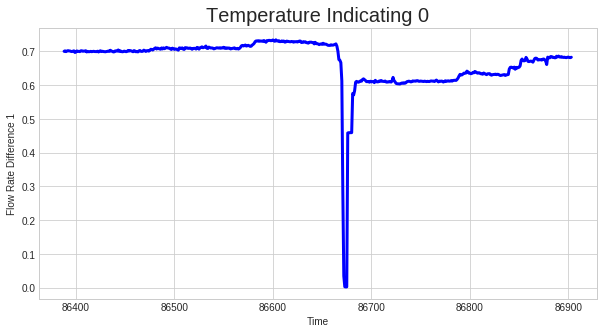

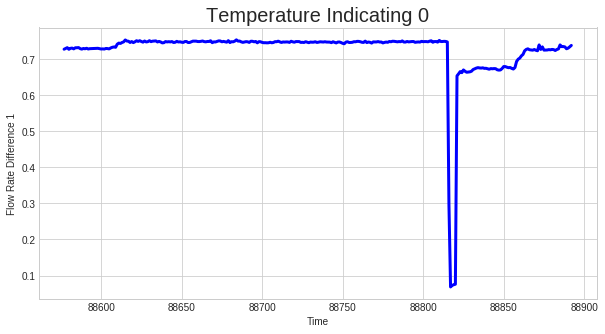

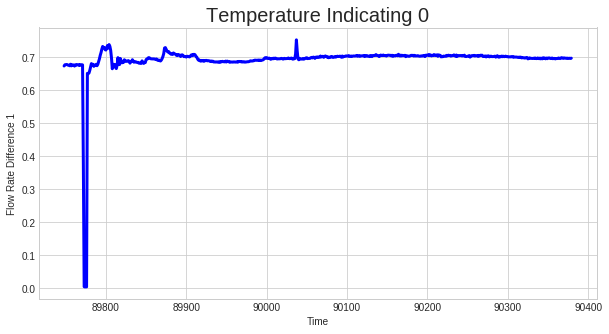

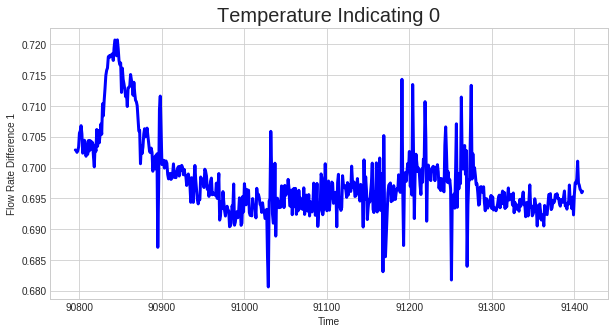

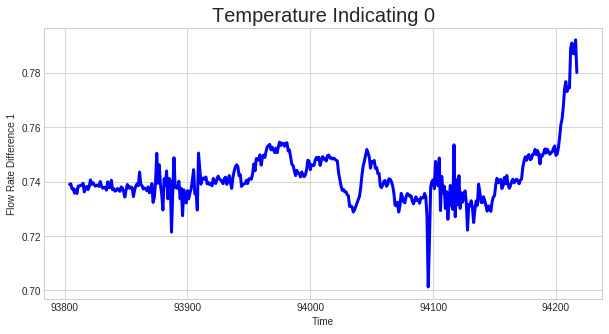

In [0]:
feature_analysis(1)

# **Generative Model-SMOTE**

In [0]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors
import pandas as pd

df = clean_data.copy()
def SMOTE(T, N, k):
  n_minority_samples, n_features = T.shape

  if N < 100:
      #create synthetic samples for subset of T.
       N = 100
       pass

  if (N % 100) != 0:
    raise ValueError("N must be < 100 or multiple of 100")

    N = N/100
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    n_features = int(n_features)
    S = np.zeros(shape=(n_synthetic_samples, n_features))

    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    #Calculate synthetic samples
    for i in range(n_minority_samples):
       nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
       #nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
       for n in range(int(N)):
          nn_index = choice(nn[0])
          #NOTE: nn includes T[i], don't want to select it
          while nn_index == i:
             nn_index = choice(nn[0])
  
          dif = T[nn_index] - T[i]
          gap = np.random.random()
          S[int(n + i * N), :] = T[i,:] + gap * dif[:]
    return S

new_data = pd.DataFrame(SMOTE(df.to_numpy(),50,10))

In [0]:
def show_new_data(feature, start=0, stop=106710):
  fig = plt.figure(figsize = (10,5))
  plt.title(data.columns[0] + " (SMOTE)", fontsize=20)
  plt.xlim = (start, stop)
  plt.ylim = (0,1)
  plt.xlabel('Time', fontsize=10)
  plt.ylabel(data.columns[feature], fontsize=10)
  p = sns.lineplot(data = new.iloc[start:stop, feature], color='r')
  plt.setp(p.lines, linewidth=3)
  plt.show()

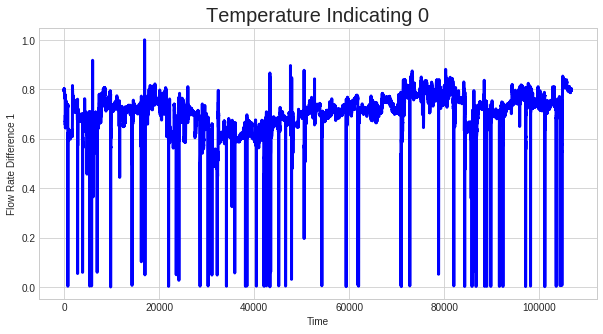

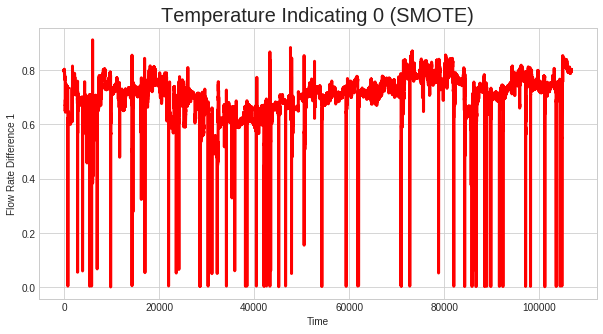

In [0]:
show(1)
show_new_data(1)